In [7]:
from rl4greencrab.envs.simple_env import SimpleEnv
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import pandas as pd
import numpy as np
from rl4greencrab import plot_agent
import ray
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

In [8]:
from rl4greencrab import greenCrabMonthEnvSimple, greenCrabMonthEnvSimpleNormalized, greenCrabMonthEnvSize, greenCrabMonthEnvSizeNormalized

In [9]:
from rl4greencrab import greenCrabMonthEnvTwoAct, greenCrabMonthEnvTwoActNormalized, greenCrabMonthEnvTwoActSize, greenCrabMonthEnvTwoActSizeNormalized

In [10]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [11]:
env = greenCrabMonthEnvTwoActNormalized(config)
vec_env = make_vec_env(greenCrabMonthEnvTwoActNormalized, n_envs=12)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision 
lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(

In [ ]:
model = PPO("MultiInputPolicy", vec_env, verbose=0)
model.learn(
	total_timesteps=1_000, 
	progress_bar=True,
)

In [12]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        'var_penalty_const': 0
        # "curriculum": True
    }
    env = greenCrabMonthEnvTwoAct(config=config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    return - m_reward

In [ ]:
ray.init()

In [ ]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 2*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

In [ ]:
evaluateConstAct(np.array([911.9806873317767, 541.2329811836053]))

In [ ]:
ray.shutdown()

In [14]:
agent_dir = '../saved_agents/twoActEnv'

In [20]:
agent_dir = '../saved_agents/twoActEnv'
td3Agent = TD3.load(f"{agent_dir}/TD3_noVar_2obs", device="cpu")
ppoAgent = PPO.load(f"{agent_dir}/PPO_noVar_2obs", device="cpu")
tqcAgent = TQC.load(f"{agent_dir}/TQC_noVar_2obs", device="cpu")
recurrentPPOAgent = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO_noVar_2obs", device="cpu")

In [21]:
recurrentPPOAgent_var = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-twoactmonthnorm-net_0", device="cpu")

In [16]:
agent_dir = '../saved_agents/twoActEnv'
recurrentPPOAgent_net = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-twoactmonthsizenorm-net_0", device="cpu")

In [24]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)

In [18]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)

In [25]:
N_EPS = 30

# ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
# td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
# tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent_net, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [26]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")

PPO mean rew = -4.0529795795560455
TQC mean rew = -3.878357023678031
TD3 mean rew = -4.370502692783167
RecurrentPPO mean rew = -21.27066986223821

In [ ]:
ppo_rew = evaluate_agent(agent=ppoAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [ ]:
ray.shutdown()

In [ ]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")

In [ ]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0,
    'control_randomness': True
    # "curriculum": True
}

In [27]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,rew,rep
0,0,-1.0,-1.0,-1.000000,-1.000000,0.000000,0
1,1,-1.0,-1.0,-1.000000,-0.652212,-0.000061,0
2,2,-1.0,-1.0,-1.000000,-0.806397,-0.014034,0
3,3,-1.0,-1.0,-1.000000,-0.328863,-0.021839,0
4,4,-1.0,-1.0,-0.715252,-0.549271,-0.048746,0


<Axes: xlabel='t'>

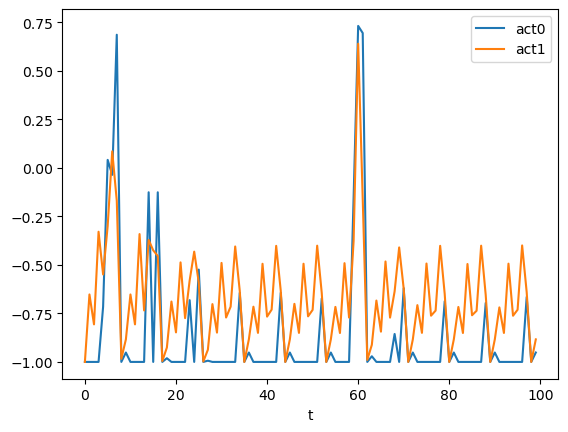

In [28]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

In [ ]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
ppoData = simulator(env = evalEnv, agent = ppoAgent_var).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF[ppoDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

In [ ]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_dict_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

In [ ]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
td3Data = simulator(env = evalEnv, agent = td3Agent_var).simulate_full_named_dict_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

In [ ]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
tqcData = simulator(env = evalEnv, agent = tqcAgent).simulate_full_named_dict_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
tqcDataDF[tqcDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

In [ ]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
tqcData = simulator(env = evalEnv, agent = tqcAgent_var).simulate_full_named_dict_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

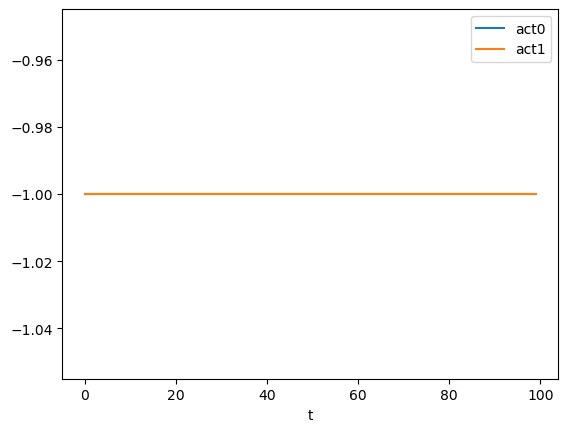

In [32]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
ppoData = simulator(env = evalEnv, agent = recurrentPPOAgent_net).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head(100)
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

In [ ]:
ppoDataDF[ppoDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

## Data Generation

In [ ]:
agent_dir = '../saved_agents/twoActEnv'
env_id = 'twoactmonthsizenorm'
td3Agent = TD3.load(f"{agent_dir}/TD3-{env_id}-1", device="cpu")
ppoAgent = PPO.load(f"{agent_dir}/PPO-{env_id}-1", device="cpu")
tqcAgent = TQC.load(f"{agent_dir}/TQC-{env_id}-1", device="cpu")
recurrentPPOAgent = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-{env_id}-1", device="cpu")

In [ ]:
td3Agent_var = TD3.load(f"{agent_dir}/TD3-{env_id}-2", device="cpu")
ppoAgent_var = PPO.load(f"{agent_dir}/PPO-{env_id}-2", device="cpu")
tqcAgent_var = TQC.load(f"{agent_dir}/TQC-{env_id}-2", device="cpu")
recurrentPPOAgent_var = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-{env_id}-2", device="cpu")

In [ ]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [ ]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")

In [ ]:
ppo_rew = evaluate_agent(agent=ppoAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [ ]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")

In [ ]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0,
    'control_randomness': True
    # "curriculum": True
}

In [ ]:
dir_name = 'greencrab_two_act_size_env/new'

### no variance penalty

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
ppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/ppo_agent_size', 
                            env=evalEnv, 
                            agent=ppoAgent, 
                            save_dir='.')
df = ppo_plot_agent.gen_env_sim_df(rep=1, obs_names=['crabs','months'])
ppo_plot_agent.save_df(ppo_plot_agent.env_simulation_df, 'ppo_size_sim_500')

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
rppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/rppo_agent_size_rep500', 
                            env=evalEnv, 
                            agent=recurrentPPOAgent, 
                            save_dir='.')
rppo_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
rppo_plot_agent.save_df(rppo_plot_agent.env_simulation_df, 'rppo_size_sim_500')

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
tqc_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/tqc_agent_size', 
                            env=evalEnv, 
                            agent=tqcAgent, 
                            save_dir='.')
tqc_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
tqc_plot_agent.save_df(tqc_plot_agent.env_simulation_df, 'tqc_size_sim_500')

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
td3_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/td3_agent_size_rep500', 
                            env=evalEnv, 
                            agent=td3Agent,
                            save_dir='.')
td3_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
td3_plot_agent.save_df(td3_plot_agent.env_simulation_df, 'td3_sim_500')

## with Variance Penalty

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
ppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/ppo_var_agent_size_rep500', 
                            env=evalEnv, 
                            agent=ppoAgent_var, 
                            save_dir='.')
df = ppo_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
ppo_plot_agent.save_df(ppo_plot_agent.env_simulation_df, 'ppo_var_size_sim_500')

In [ ]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
td3_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/td3_var_agent_size_rep500', 
                            env=evalEnv, 
                            agent=td3Agent_var,
                            save_dir='.')
td3_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
td3_plot_agent.save_df(td3_plot_agent.env_simulation_df, 'td3_var_size_sim_500')